In [343]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from SineGeneration.analyze_models_sl import make_axis_nice, set_plt_params
np.random.seed(1234)
set_plt_params(style='fast')

In [153]:
def activation_func(x):
    return np.tanh(x)

def update_weights(presynaptic, postsynaptic, current_weights, lr: float = 1e-3):
    dw = (postsynaptic[:, None] @ presynaptic[None, :] - np.diag(postsynaptic ** 2) @ current_weights) * lr
    return current_weights + dw

In [4]:
n_neurons, latent_rank, n_trials, duration = 500, 30, 20, 750
input_tau = .05
times = np.linspace(0, 1, duration)

time_distances = np.exp(-(times[:, None] - times[None, :]) ** 2 / input_tau**2)
input = np.random.multivariate_normal(np.zeros(duration), time_distances)
dt, tau = 0.01, 0.05

J_0 = np.random.randn(n_neurons, n_neurons) / np.sqrt(n_neurons)
U = np.random.randn(n_neurons, latent_rank) / np.sqrt(latent_rank)
V = np.random.randn(n_neurons, latent_rank) / np.sqrt(latent_rank)
I = np.random.randn(n_neurons)
J = J_0 + U @ V.T

In [5]:
x_0 = np.random.randn(n_neurons, n_trials)
r = activation_func(x_0)
r_store = np.zeros((n_neurons, duration, n_trials))
x = x_0.copy()
for ti in range(duration):
    x += dt/tau * (-x + J @ r + (I * input[ti])[:, None])
    r = activation_func(x)
    r_store[:, ti] = r


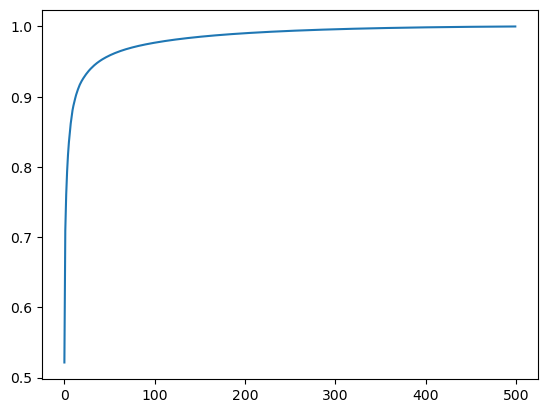

In [6]:
r_flat = r_store.reshape(n_neurons, duration* n_trials).T
pca = PCA()
pca.fit(r_flat)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [7]:
n_trials = 100
noise = np.random.randn(n_neurons, duration, n_trials)
x_0 = np.random.randn(n_neurons, n_trials)
r = activation_func(x_0)
r_store = np.zeros((n_neurons, duration, n_trials))
x = x_0.copy()
for ti in range(duration):
    x += dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
    r = activation_func(x)
    r_store[:, ti] = r
noise_flat = noise.reshape(n_neurons, duration* n_trials).T
exploration_flat = (r_store - r_store.mean(axis=(0, 2))[None, :, None]).reshape(n_neurons, duration* n_trials).T

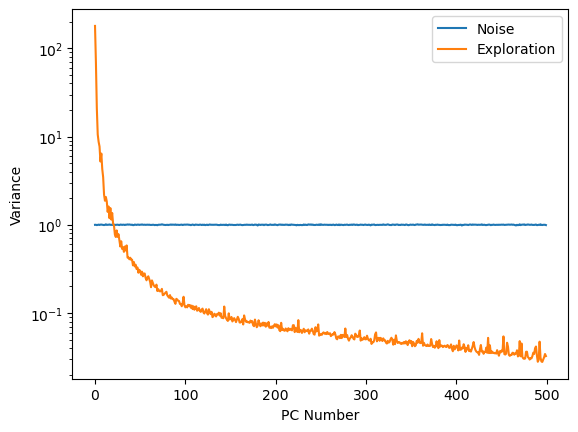

In [9]:
noise_transformed = pca.transform(noise_flat)
exploration_signal_transform = pca.transform(exploration_flat)
var_across = noise_transformed.var(axis=0)
exploration_var_across = exploration_signal_transform.var(axis=0)

plt.plot(var_across, label='Noise')
plt.plot(exploration_var_across, label='Exploration')
plt.xlabel('PC Number')
plt.ylabel('Variance')
plt.yscale('log')
plt.legend()

Obviously this rate of exploration in the higher dimensions will be costly if the rewarding axis is actually one of the higher dimensions and should lead to an exponential speed up in the amount needed to learn. The solution would be to inject variability into the dimensions most correlated with reward.

We'll add another network that uses hebbian and anti-hebbian learning to pull out the PCS from the original network

In [10]:
def create_rectangular_matrix_with_1s_on_diagonal(rows, cols):
  """Creates a rectangular matrix with 1s on the diagonal.

  Args:
    rows: The number of rows in the matrix.
    cols: The number of columns in the matrix.

  Returns:
    A rectangular matrix with 1s on the diagonal.
  """

  matrix = np.zeros((rows, cols))
  for i in range(rows):
    matrix[i, i] = 1
      
  return matrix

In [160]:
def generate_data(pca_fit, pc: int = 0, samples: int = 500):
    values = np.random.randn(samples)
    npcs = pca_fit.n_components_
    pcs = np.zeros((npcs, samples))
    pcs[pc] = values
    transformed_data = pca_fit.inverse_transform(pcs.T).T
    return transformed_data

In [178]:
n_neurons_bg = int(.1 * n_neurons)
runs = 2
mds_scores = []
for run in range(runs):
    W_ff = np.random.randn(n_neurons_bg, n_neurons) / np.sqrt(n_neurons)
    W_fb = np.random.randn(n_neurons_bg, n_neurons_bg) / np.sqrt(n_neurons_bg)
    noise_bg = np.random.randn(n_neurons_bg, duration, 1)
    lr = 1e-4
    trials = 25
    diag_mat = create_rectangular_matrix_with_1s_on_diagonal(n_neurons_bg, n_neurons)
    running_activity = 0
    r_mean = np.zeros((n_neurons, 1))
    r_bg_mean = np.zeros((n_neurons_bg, 1))
    n_updates = 0
    for trial in range(trials):
        noise = np.random.randn(n_neurons, duration, 1)
        x_0 = np.random.randn(n_neurons, 1)
        bg_0 = np.random.randn(n_neurons_bg, 1)
        r = activation_func(x_0)
        r_bg = activation_func(bg_0)
        r_store = np.zeros((n_neurons, duration, 1))
        r_bg_store = np.zeros((n_neurons_bg, duration, 1))
        x = x_0.copy()
        x_bg = bg_0.copy()
        for ti in range(duration):
            x += dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
            r = activation_func(x)
            r_store[:, ti] = r
            r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r)
            r_bg_store[:, ti] = r_bg
            # running_activity += r_bg ** 2
            W_ff = update_weights((r).squeeze(), r_bg.squeeze(),
                                  W_ff, lr)
            W_fb = update_weights(r_bg.squeeze(), r_bg.squeeze(), W_fb, lr)
            np.fill_diagonal(W_fb, 0)
            n_updates += 1
    
        r_mean = r_store.mean(axis=(1,2))[:, np.newaxis]
        r_bg_mean = r_bg_store.mean(axis=(1, 2))[:, np.newaxis]
    
    components = pca.components_
    weight_projections = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ W_ff @ components.T
    contributions = (weight_projections ** 2).sum(axis=0)
    contributions /= contributions.max()
    mds_scores.append(contributions)
mds_score = np.vstack(mds_scores)

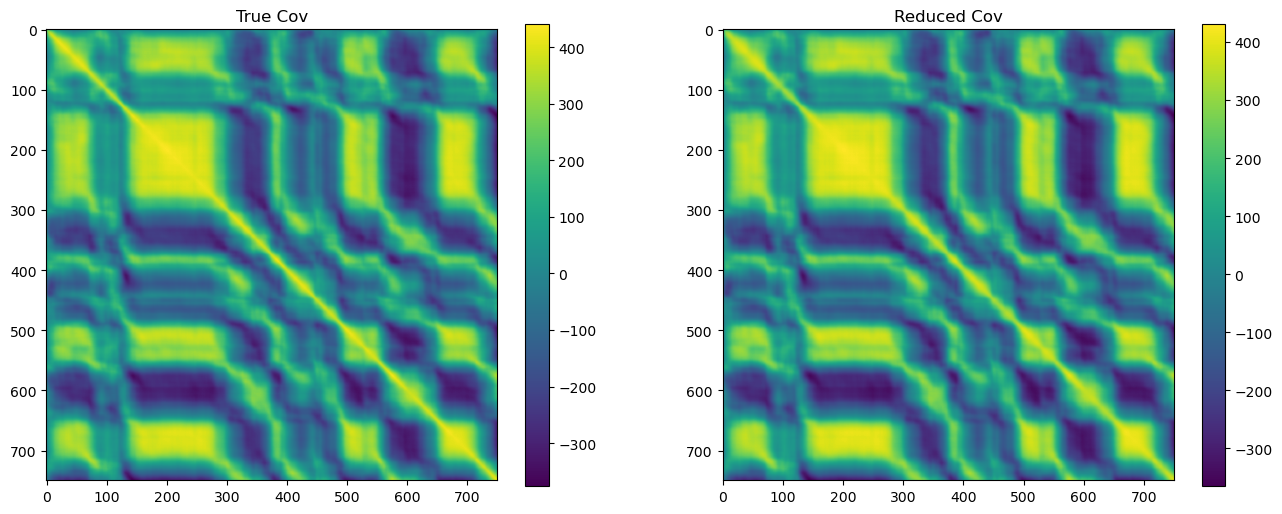

In [163]:
og_dist = (r_store.squeeze() ).T @ (r_store.squeeze())
dist = (r_bg_store.squeeze()).T @ (r_bg_store.squeeze())
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].set_title('True Cov')
g0 = ax[0].imshow(og_dist)
plt.colorbar(g0, ax=ax[0])
ax[1].set_title('Reduced Cov')
g1 = ax[1].imshow(dist)
plt.colorbar(g1, ax=ax[1])

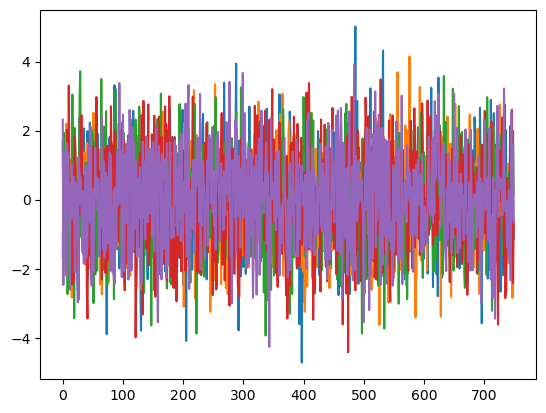

In [42]:
noise = np.random.randn(n_neurons, duration, 1)
noise_bg = np.random.randn(n_neurons_bg, duration, 1)

x_0 = np.random.randn(n_neurons, 1)
bg_0 = np.random.randn(n_neurons_bg, 1)
r = activation_func(x_0)
r_bg = activation_func(bg_0)
r_store = np.zeros((n_neurons, duration, 1))
r_bg_store = np.zeros((n_neurons_bg, duration, 1))
x = x_0.copy()
x_bg = bg_0.copy()
for ti in range(duration):
    x = noise[:, ti]
    r = x #activation_func(x)
    r_store[:, ti] = r
    r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r) + noise_bg[:, ti]
    r_bg_store[:, ti] = r_bg
pcs = pca.transform(r_store.squeeze().T).T
plt.plot(r_bg_store[:5, :].squeeze().T)

In [43]:
def linear_regression(features, targets, kappa: float = 1e-3):
    #expects targets and features to be [features, samples]
    
    # zero mean targets and predictors
    features_mean = features.mean(axis=1)
    target_mean = targets.mean(axis=1)
    features -= features_mean[:, None]
    targets -= target_mean
    
    coeffs = np.linalg.inv(features @ features.T - kappa * np.eye(features.shape[0])) @ features @ targets.T
    model_prediction = (coeffs.T @ features).squeeze()
    corr_coeff = np.corrcoef(model_prediction, targets.squeeze())[0, 1] ** 2
    return coeffs, model_prediction, targets.squeeze(), corr_coeff

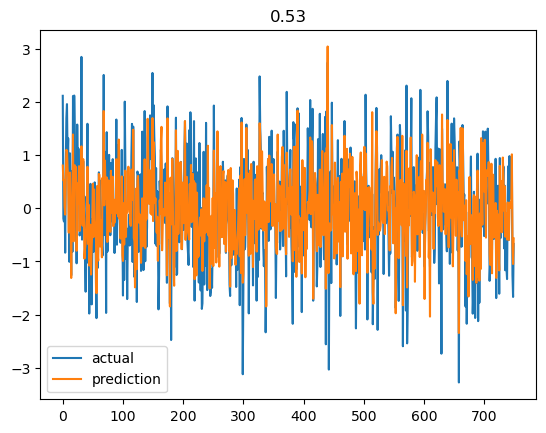

In [44]:
lin_coefs, prediction, actual, corr_coeff = linear_regression(r_bg_store.squeeze(), pcs[0][None, :])
plt.title(f"{corr_coeff:.2f}")
plt.plot(actual, label='actual')
plt.plot(prediction, label='prediction')
plt.legend()

In [46]:
score = []
for pc in range(pcs.shape[0]):
    _, _, _, corr_coeff = linear_regression(r_bg_store.squeeze(), pcs[pc][None, :])
    score.append(corr_coeff)

In [47]:
mds_score = []
samples = 5
for sample in range(samples):
    reward = np.zeros(n_neurons)
    for pc in range(n_neurons):
        xs = generate_data(pca, pc)
        r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ xs)
        # mds_error = 1 - ((xs.T @ xs - (r_bg.T @ r_bg) ) ** 2).sum() / ((xs.T @ xs - (xs.T @ xs).mean(axis=0)) ** 2).sum()
        mds_error = 1 - (np.trace( (r_bg.T @ r_bg) @ (xs.T @ xs))) / (np.linalg.norm(xs.T @ xs) * np.linalg.norm(r_bg.T @ r_bg)) # distance metric from herdin (2005) Correlation Matrix Distance
        reward[pc] = mds_error
    mds_score.append(reward)
mds_score = np.vstack(mds_score)

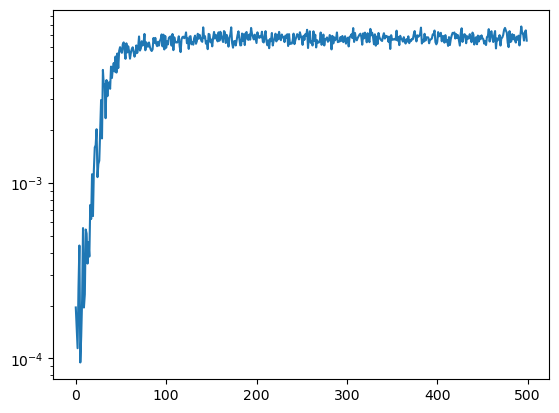

In [50]:
plt.plot(mds_score.mean(axis=0))
plt.yscale('log')

Text(0, 0.5, 'Score')

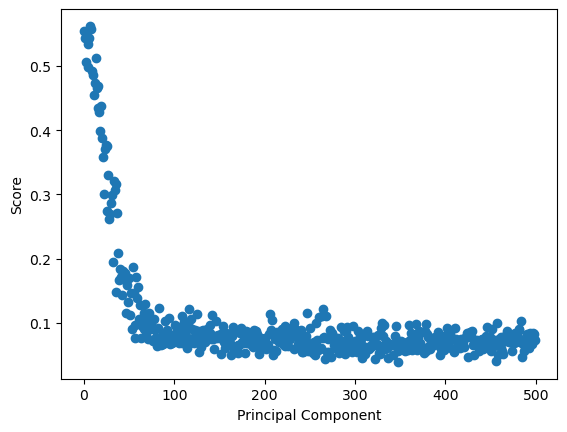

In [23]:
plt.scatter(np.arange(len(score)), score)
plt.xlabel('Principal Component')
plt.ylabel('Score')

Can we shift the extracted PCs with rewards?

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

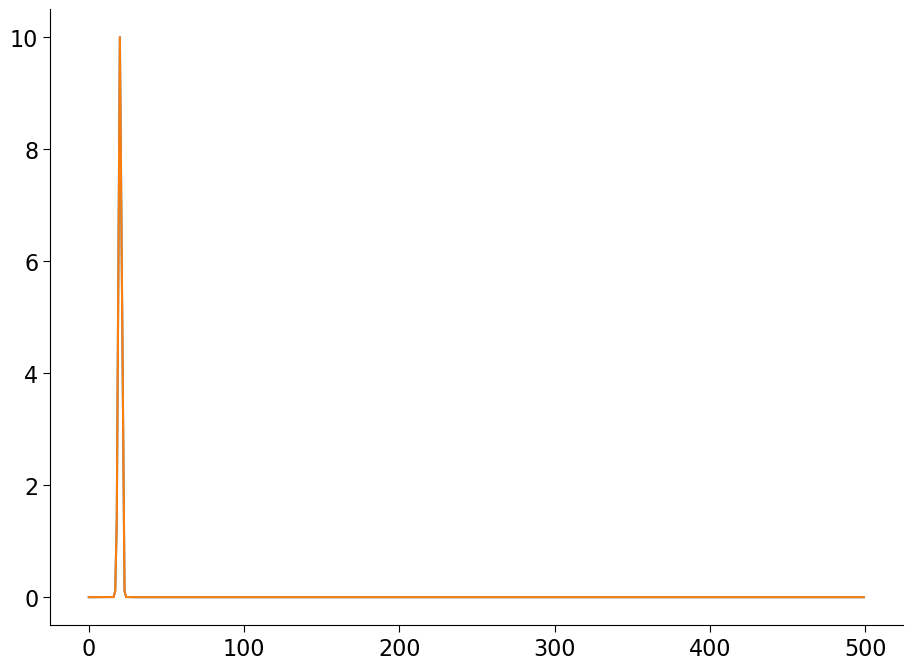

In [361]:
n_neurons_bg = int(.1 * n_neurons)
rewarded_dim = 20
sing_vals = pca.singular_values_
gamma = 1
weights = 10 * np.exp(-((np.arange(sing_vals.shape[0]) - rewarded_dim)/gamma) ** 2 / 2)
plt.plot(weights)
plt.pause(.1)

In [229]:
runs = 4
mds_rewarded_scores = []
W_rpe = np.random.randn(n_neurons_bg)
for run in range(runs):
    noise_bg = np.random.randn(n_neurons_bg, duration, 1)
    W_ff = np.random.randn(n_neurons_bg, n_neurons) / np.sqrt(n_neurons)
    W_fb = np.random.randn(n_neurons_bg, n_neurons_bg) / np.sqrt(n_neurons_bg)
    U = np.random.randn(n_neurons, n_neurons_bg) / np.sqrt(n_neurons_bg)
    # lr = 0.0001
    lr = 1e-4
    diag_mat = create_rectangular_matrix_with_1s_on_diagonal(n_neurons_bg, n_neurons)
    all_rewards = []
    running_activity = 0
    r_mean = np.zeros((n_neurons, 1))
    r_bg_mean = np.zeros((n_neurons_bg, 1))
    current_updates = 0
    # while current_updates <= n_updates:
    # for trial in range(trials):
    while current_updates <= n_updates:
        noise = np.random.randn(n_neurons, duration, 1)
        x_0 = np.random.randn(n_neurons, 1)
        bg_0 = np.random.randn(n_neurons_bg, 1)
        r = activation_func(x_0)
        r_store = np.zeros((n_neurons, duration, 1))
        r_bg_store = np.zeros((n_neurons_bg, duration, 1))
        x = x_0.copy()
        r_bg = bg_0.copy()
        # running_activity = 0
        for ti in range(duration):
            prev_projections = pca.transform(r.T).squeeze()
            dx = dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None]) # + U @ r_bg
            x += dx
            r = activation_func(x)
            r_store[:, ti] = r
            projections = pca.transform(r.T).squeeze()
            reward_magnitude = (weights * (projections ** 2 / (.25 * np.sqrt(sing_vals)))).sum() / n_neurons_bg
            all_rewards.append(reward_magnitude)
            r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r + (W_rpe * reward_magnitude)[:, np.newaxis])
            r_bg_store[:, ti] = r_bg
            # running_activity += reward_magnitude * (r_bg) ** 2
            if reward_magnitude > .1:
                W_ff = update_weights(reward_magnitude * r.squeeze(), r_bg.squeeze(),
                                      W_ff, lr)
                current_updates += 1
            W_fb = update_weights((r_bg).squeeze(),(r_bg).squeeze(), W_fb, lr)
            # U += lr * (dx @ (r_bg - r_bg_mean).T - U) * (reward_magnitude)
            np.fill_diagonal(W_fb, 0)
            r_bg_store[:, ti] = r_bg
        r_mean = r_store.mean(axis=(1,2))[:, np.newaxis]
        r_bg_mean = r_bg_store.mean(axis=(1, 2))[:, np.newaxis]
        
    # mds_score_reward = []
    # samples = 5
    # for sample in range(samples):
    #     reward = np.zeros(n_neurons)
    #     for pc in range(n_neurons):
    #         xs = generate_data(pca, pc)
    #         r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ xs)
    #         mds_error = 1 - (np.trace( (r_bg.T @ r_bg) @ (xs.T @ xs))) / (np.linalg.norm(xs.T @ xs) * np.linalg.norm(r_bg.T @ r_bg)) # distance metric from herdin (2005) Correlation Matrix Distance
    #         reward[pc] = mds_error
    #     mds_score_reward.append(reward)
    components = pca.components_
    weight_projections = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ W_ff @ components.T
    contributions = (weight_projections ** 2).sum(axis=0)
    contributions /= contributions.max()
    # mds_score_reward = np.vstack(mds_score_reward)
    # mean_reward = mds_score_reward.mean(axis=0)
    mds_rewarded_scores.append(contributions)
mds_score_reward = np.vstack(mds_rewarded_scores)


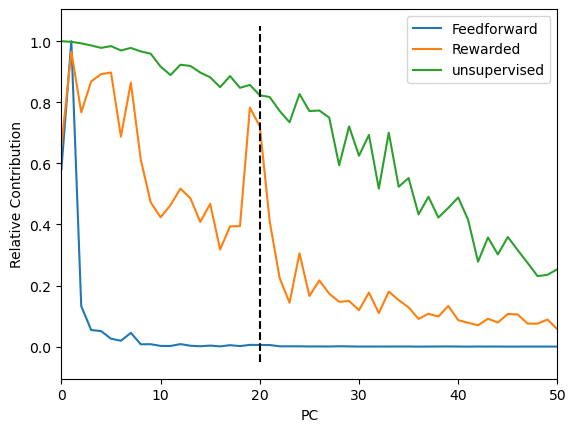

In [230]:
components = pca.components_
weight_projections = W_ff @ components.T
contributions = (weight_projections ** 2).sum(axis=0)
contributions /= contributions.max()
plt.plot(contributions, label='Feedforward')
plt.plot(mds_score_reward.mean(axis=0), label='Rewarded')
plt.plot(mds_score.mean(axis=0), label='unsupervised')
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--')
plt.xlim([0, 50])
plt.xlabel('PC')
plt.ylabel('Relative Contribution')
plt.legend()

In [81]:
noise = np.random.randn(n_neurons, duration, 1)
noise_bg = np.random.randn(n_neurons_bg, duration, 1)

x_0 = np.random.randn(n_neurons, 1)
bg_0 = np.random.randn(n_neurons_bg, 1)
r = activation_func(x_0)
r_bg = activation_func(bg_0)
r_store = np.zeros((n_neurons, duration, 1))
r_bg_store = np.zeros((n_neurons_bg, duration, 1))
x = x_0.copy()
x_bg = bg_0.copy()
for ti in range(duration):
    x = noise[:, ti]
    r = x #activation_func(x)
    r_store[:, ti] = r
    r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r) + noise_bg[:, ti]
    r_bg_store[:, ti] = r_bg
pcs = pca.transform(r_store.squeeze().T).T

In [82]:
score_reward = []
for pc in range(pcs.shape[0]):
    _, _, _, corr_coeff = linear_regression(r_bg_store.squeeze(), pcs[pc][None, :])
    score_reward.append(corr_coeff)

In [93]:
mds_score_reward = []
samples = 5
for sample in range(samples):
    reward = np.zeros(n_neurons)
    for pc in range(n_neurons):
        xs = generate_data(pca, pc)
        r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ xs)
        mds_error = 1 - (np.trace( (r_bg.T @ r_bg) @ (xs.T @ xs))) / (np.linalg.norm(xs.T @ xs) * np.linalg.norm(r_bg.T @ r_bg)) # distance metric from herdin (2005) Correlation Matrix Distance
        reward[pc] = mds_error
    mds_score_reward.append(reward)
mds_score_reward = np.vstack(mds_score_reward)

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

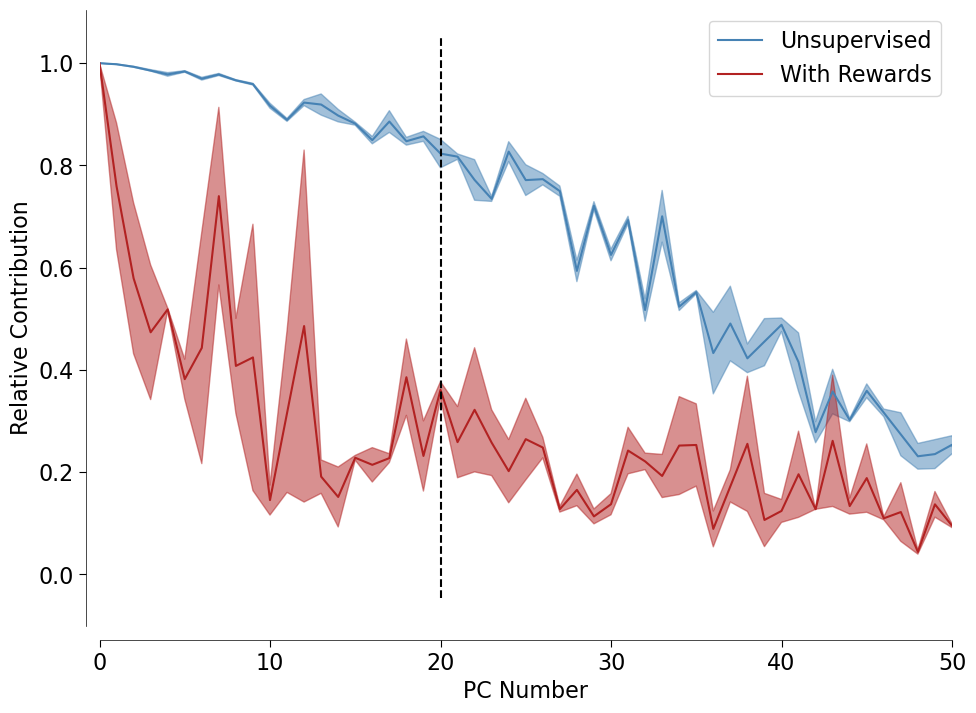

In [346]:
mean_mds = mds_score.mean(axis=0)
std_mds = mds_score.std(axis=0)
plt.plot(np.arange(n_neurons), mean_mds, label='Unsupervised', color='steelblue')
plt.fill_between(np.arange(n_neurons), mean_mds - std_mds, mean_mds + std_mds, color='steelblue', alpha=.5)
mean_mds_rewarded = mds_score_reward.mean(axis=0)
std_mds_rewarded = mds_score_reward.std(axis=0)

plt.plot(np.arange(n_neurons), mean_mds_rewarded, label='With Rewards', color='firebrick')
plt.fill_between(np.arange(n_neurons), mean_mds_rewarded - std_mds_rewarded, mean_mds_rewarded + std_mds_rewarded, color='firebrick', alpha=.5)
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--')
# plt.yscale('log')
plt.legend()
plt.ylabel('Relative Contribution')
plt.xlabel('PC Number')
plt.xlim([0,50])
make_axis_nice()
plt.pause(.1)

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

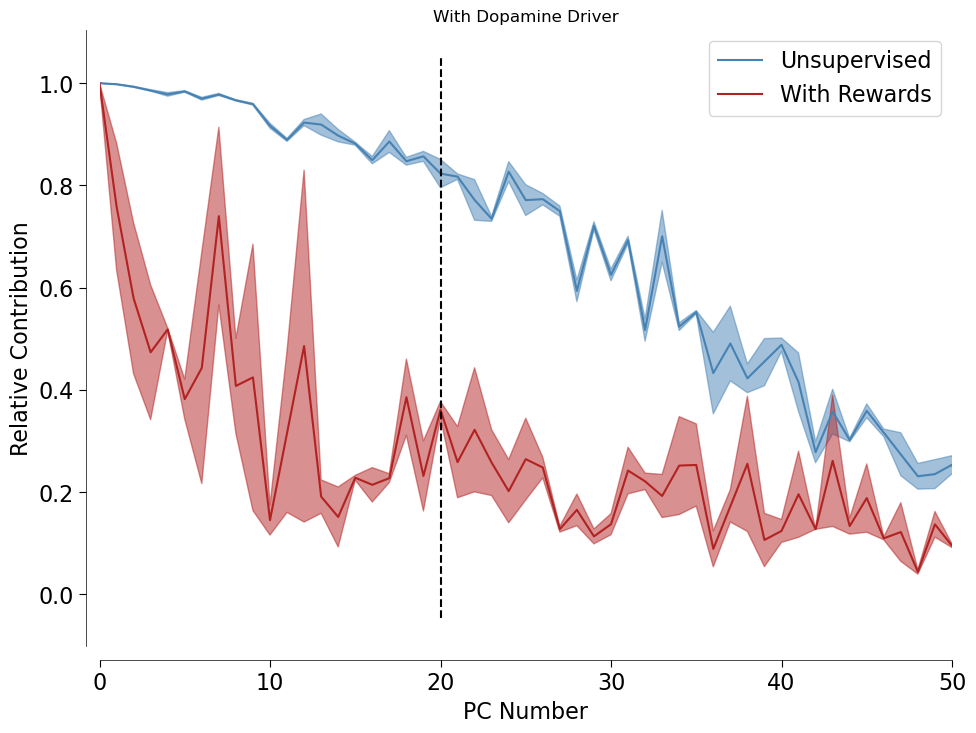

In [347]:
mean_mds = mds_score.mean(axis=0)
std_mds = mds_score.std(axis=0)
plt.plot(np.arange(n_neurons), mean_mds, label='Unsupervised', color='steelblue')
plt.fill_between(np.arange(n_neurons), mean_mds - std_mds, mean_mds + std_mds, color='steelblue', alpha=.5)
mean_mds_rewarded = mds_score_reward.mean(axis=0)
std_mds_rewarded = mds_score_reward.std(axis=0)

plt.plot(np.arange(n_neurons), mean_mds_rewarded, label='With Rewards', color='firebrick')
plt.fill_between(np.arange(n_neurons), mean_mds_rewarded - std_mds_rewarded, mean_mds_rewarded + std_mds_rewarded, color='firebrick', alpha=.5)
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--')
# plt.yscale('log')
plt.legend()
plt.title('With Dopamine Driver')
plt.ylabel('Relative Contribution')
plt.xlabel('PC Number')
plt.xlim([0,50])
make_axis_nice()
plt.pause(.1)


Now Can we also learn the direction that cortex should be pushed in?

In [362]:
runs = 25
mds_rewarded_scores = []
mds_rewarded_scores_ff = []
noise_variability = []
ctx_exploration = []
ctx_nbg_exploration = []
for run in range(runs):
    W_rpe = np.random.randn(n_neurons_bg)
    noise_bg = np.random.randn(n_neurons_bg, duration, 1)
    W_ff = np.random.randn(n_neurons_bg, n_neurons) / np.sqrt(n_neurons)
    W_fb = np.random.randn(n_neurons_bg, n_neurons_bg) / np.sqrt(n_neurons_bg)
    U = np.random.randn(n_neurons, n_neurons_bg) / np.sqrt(n_neurons_bg)
    # lr = 0.0001
    lr = 1e-4
    diag_mat = create_rectangular_matrix_with_1s_on_diagonal(n_neurons_bg, n_neurons)
    all_rewards = []
    running_activity = 0
    r_mean = np.zeros((n_neurons, 1))
    r_bg_mean = np.zeros((n_neurons_bg, 1))
    current_updates = 0
    # while current_updates <= n_updates:
    # for trial in range(trials):
    while current_updates <= n_updates:
        noise = np.random.randn(n_neurons, duration, 1)
        x_0 = np.random.randn(n_neurons, 1)
        bg_0 = np.random.randn(n_neurons_bg, 1)
        r = activation_func(x_0)
        r_store = np.zeros((n_neurons, duration, 1))
        r_bg_store = np.zeros((n_neurons_bg, duration, 1))
        x = x_0.copy()
        r_bg = bg_0.copy()
        # running_activity = 0
        for ti in range(duration):
            prev_projections = pca.transform(r.T).squeeze()
            dx = dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None]) + U @ r_bg
            x += dx
            r = activation_func(x)
            r_store[:, ti] = r
            projections = pca.transform(r.T).squeeze()
            reward_magnitude = (weights * (projections ** 2 / (.25 * np.sqrt(sing_vals)))).sum() / n_neurons_bg
            all_rewards.append(reward_magnitude)
            r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r + (W_rpe * reward_magnitude)[:, np.newaxis] + noise_bg[:, ti])
            r_bg_store[:, ti] = r_bg
            # running_activity += reward_magnitude * (r_bg) ** 2
            if reward_magnitude > .1:
                W_ff = update_weights(reward_magnitude * r.squeeze(), r_bg.squeeze(),
                                      W_ff, lr)
                U += lr / 10 * (dx @ r_bg.T - U) * reward_magnitude
                current_updates += 1
            W_fb = update_weights((r_bg).squeeze(),(r_bg).squeeze(), W_fb, lr)
            np.fill_diagonal(W_fb, 0)
            r_bg_store[:, ti] = r_bg
        r_mean = r_store.mean(axis=(1,2))[:, np.newaxis]
        r_bg_mean = r_bg_store.mean(axis=(1, 2))[:, np.newaxis]
        
    components = pca.components_
    weight_projections = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ W_ff @ components.T
    contributions = (weight_projections ** 2).sum(axis=0)
    contributions /= contributions.max()
    mds_rewarded_scores.append(contributions)
    
    weight_projections = W_ff @ components.T
    contributions = (weight_projections ** 2).sum(axis=0)
    contributions /= contributions.max()
    mds_rewarded_scores_ff.append(contributions)
    
    n_trials = 10
    noise = np.random.randn(n_neurons, duration, n_trials)
    x_0 = np.random.randn(n_neurons, n_trials)
    r = activation_func(x_0)
    r_store = np.zeros((n_neurons, duration, n_trials))
    x = x_0.copy()
    bg_0 = np.random.randn(n_neurons_bg, 1)
    r_bg = bg_0.copy()
    for ti in range(duration):
        x += dt / tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
        r = activation_func(x)
        r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r)
        r_store[:, ti] = r
    exploration_flat_no_bg = (r_store - r_store.mean(axis=(0, 2))[None, :, None]).reshape(n_neurons, duration * n_trials).T
    
    noise = np.random.randn(n_neurons, duration, n_trials)
    x_0 = np.random.randn(n_neurons, n_trials)
    r = activation_func(x_0)
    r_store = np.zeros((n_neurons, duration, n_trials))
    x = x_0.copy()
    bg_0 = np.random.randn(n_neurons_bg, n_trials)
    r_bg = bg_0.copy()
    for ti in range(duration):
        x += dt / tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None]) + U @ r_bg
        r = activation_func(x)
        r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r)
        r_store[:, ti] = r
    noise_flat = noise.reshape(n_neurons, duration * n_trials).T
    exploration_flat = (r_store - r_store.mean(axis=(0, 2))[None, :, None]).reshape(n_neurons, duration * n_trials).T
    noise_transformed = pca.transform(noise_flat)
    exploration_signal_transform = pca.transform(exploration_flat)
    exploration_signal_transform_no_bg = pca.transform(exploration_flat_no_bg)
    
    var_across = noise_transformed.var(axis=0)
    exploration_var_across = exploration_signal_transform.var(axis=0)
    exploration_var_across_no_bg = exploration_signal_transform_no_bg.var(axis=0)
    
    noise_variability.append(var_across)
    ctx_exploration.append(exploration_var_across)
    ctx_nbg_exploration.append(exploration_var_across_no_bg)
mds_score_reward = np.vstack(mds_rewarded_scores)
mds_score_reward_ff = np.vstack(mds_rewarded_scores_ff)
noise_variability = np.vstack(noise_variability)
ctx_exploration = np.vstack(ctx_exploration)
ctx_nbg_exploration = np.vstack(ctx_nbg_exploration)

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

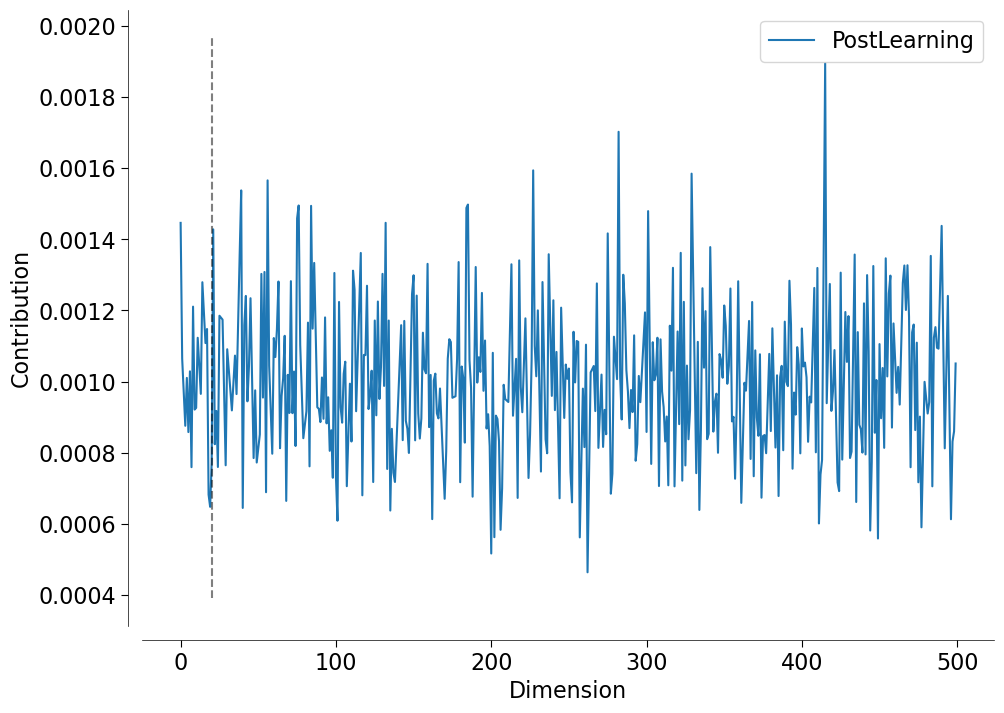

In [352]:
u_dir = (U / np.linalg.norm(U))
contributions = (u_dir.T @ components.T).squeeze() ** 2 ** 1/2
plt.plot(contributions.sum(axis=0), label='PostLearning')
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--', alpha=.5)
plt.xlabel('Dimension')
plt.ylabel('Contribution')
plt.legend()
make_axis_nice()
plt.pause(.1)

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

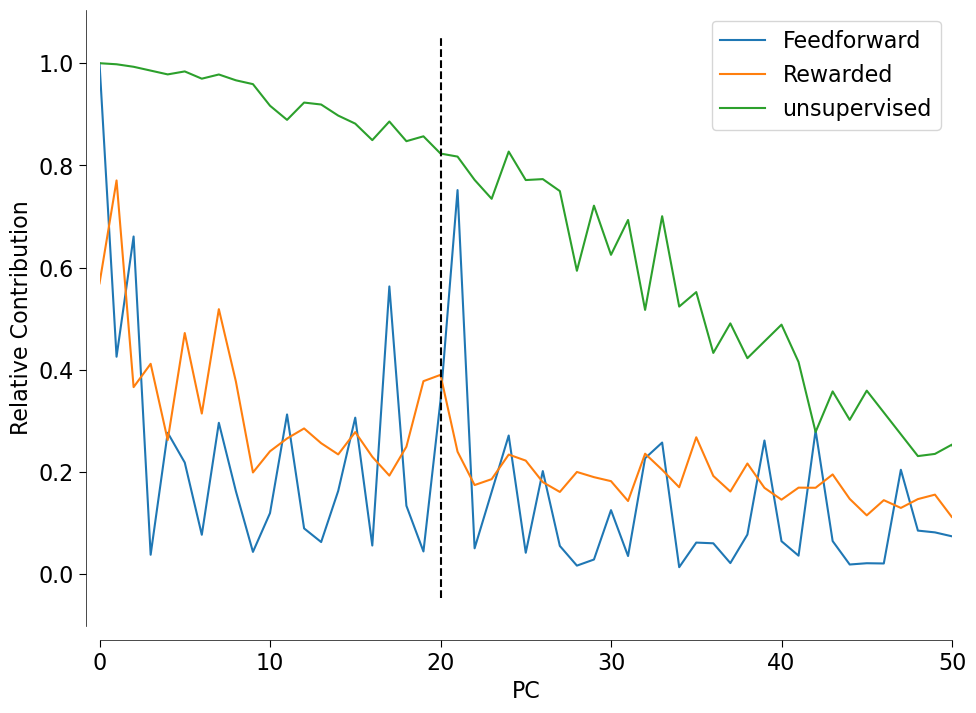

In [353]:
components = pca.components_
weight_projections = W_ff @ components.T
contributions = (weight_projections ** 2).sum(axis=0)
contributions /= contributions.max()
plt.plot(contributions, label='Feedforward')
plt.plot(mds_score_reward.mean(axis=0), label='Rewarded')
plt.plot(mds_score.mean(axis=0), label='unsupervised')
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--')
plt.xlim([0, 50])
plt.xlabel('PC')
plt.ylabel('Relative Contribution')
plt.legend()
make_axis_nice()
plt.pause(.1)

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

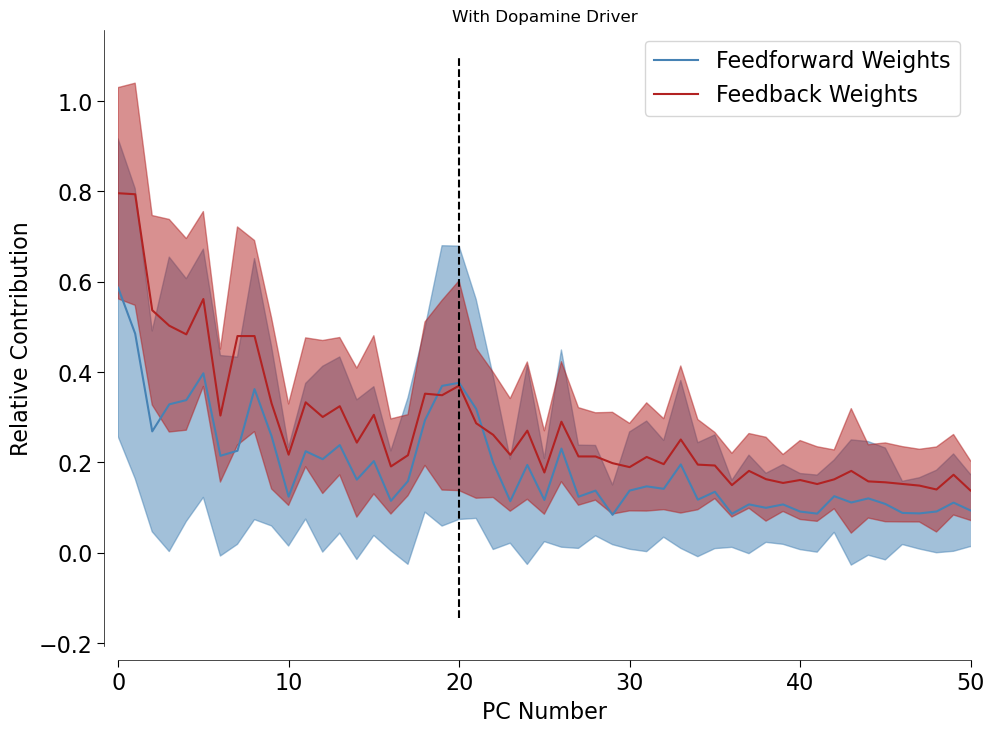

In [363]:
mean_mds_ff = mds_score_reward_ff.mean(axis=0)
std_mds_ff = mds_score_reward_ff.std(axis=0)
plt.plot(np.arange(n_neurons), mean_mds_ff, label='Feedforward Weights', color='steelblue')
plt.fill_between(np.arange(n_neurons), mean_mds_ff - std_mds_ff, mean_mds_ff + std_mds_ff, color='steelblue', alpha=.5)
mean_mds_rewarded = mds_score_reward.mean(axis=0)
std_mds_rewarded = mds_score_reward.std(axis=0)

plt.plot(np.arange(n_neurons), mean_mds_rewarded, label='Feedback Weights', color='firebrick')
plt.fill_between(np.arange(n_neurons), mean_mds_rewarded - std_mds_rewarded, mean_mds_rewarded + std_mds_rewarded, color='firebrick', alpha=.5)
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--')
# plt.yscale('log')
plt.legend()
plt.title('With Dopamine Driver')
plt.ylabel('Relative Contribution')
plt.xlabel('PC Number')
plt.xlim([0,50])
make_axis_nice()
plt.pause(.1)

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

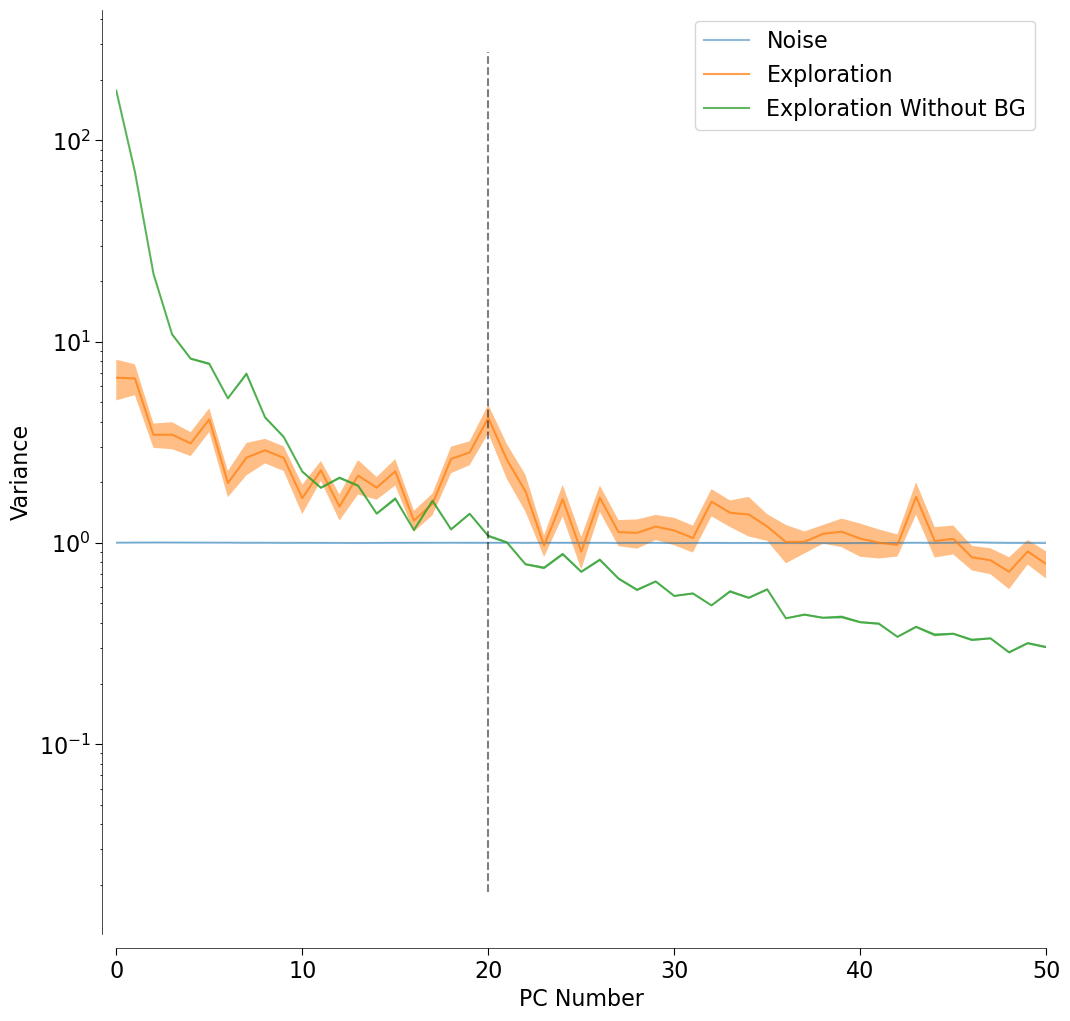

In [365]:
var_across = noise_variability.mean(axis=0)
exploration_var_across = ctx_exploration.mean(axis=0)
exploration_var_across_no_bg = ctx_nbg_exploration.mean(axis=0)

var_across_std = noise_variability.std(axis=0) / np.sqrt(noise_variability.shape[0])
exploration_var_across_std = ctx_exploration.std(axis=0) / np.sqrt(ctx_exploration.shape[0])
exploration_var_across_no_bg_std = ctx_nbg_exploration.std(axis=0) / np.sqrt(ctx_nbg_exploration.shape[0])

plt.figure(figsize=(12, 12))
plt.plot(var_across, label='Noise', alpha=.5)
plt.fill_between(np.arange(var_across.shape[0]), var_across - var_across_std, var_across + var_across_std, alpha=.5)
plt.plot(exploration_var_across, label='Exploration', alpha=.75)
plt.fill_between(np.arange(exploration_var_across.shape[0]), exploration_var_across - exploration_var_across_std,
                 exploration_var_across + exploration_var_across_std, alpha=.5)
plt.plot(exploration_var_across_no_bg, label='Exploration Without BG', alpha=.75)
plt.fill_between(np.arange(exploration_var_across_no_bg.shape[0]), exploration_var_across_no_bg - exploration_var_across_no_bg_std,
                 exploration_var_across_no_bg + exploration_var_across_no_bg_std, alpha=.5)

plt.xlabel('PC Number')
plt.ylabel('Variance')
plt.yscale('log')
y_lims = plt.gca().get_ylim()
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--', alpha=0.5)
plt.legend()
plt.xlim([0, 50])
make_axis_nice()
plt.pause(.1)

In [366]:
n_neurons_bg = int(.1 * n_neurons)
previous_rewarded_dim = rewarded_dim
rewarded_dim = 100
sing_vals = pca.singular_values_
gamma = 1
weights = 10 * np.exp(-((np.arange(sing_vals.shape[0]) - rewarded_dim)/gamma) ** 2 / 2)
plt.plot(weights)
runs = 4
mds_rewarded_scores = []
W_rpe = np.random.randn(n_neurons_bg)
mds_rewarded_scores = []
mds_rewarded_scores_ff = []
noise_bg = np.random.randn(n_neurons_bg, duration, 1)
# lr = 0.0001
lr = 1e-4
all_rewards = []
running_activity = 0
current_updates = 0

while current_updates <= n_updates:
    noise = np.random.randn(n_neurons, duration, 1)
    x_0 = np.random.randn(n_neurons, 1)
    bg_0 = np.random.randn(n_neurons_bg, 1)
    r = activation_func(x_0)
    r_store = np.zeros((n_neurons, duration, 1))
    r_bg_store = np.zeros((n_neurons_bg, duration, 1))
    x = x_0.copy()
    r_bg = bg_0.copy()
    for ti in range(duration):
        prev_projections = pca.transform(r.T).squeeze()
        dx = dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None]) + U @ r_bg
        x += dx
        r = activation_func(x)
        r_store[:, ti] = r
        projections = pca.transform(r.T).squeeze()
        reward_magnitude = (weights * (projections ** 2 / (.25 * np.sqrt(sing_vals)))).sum() / n_neurons_bg
        all_rewards.append(reward_magnitude)
        r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r + (W_rpe * reward_magnitude)[:, np.newaxis])
        r_bg_store[:, ti] = r_bg
        # running_activity += reward_magnitude * (r_bg) ** 2
        if reward_magnitude > .1:
            W_ff = update_weights(reward_magnitude * r.squeeze(), r_bg.squeeze(),
                                  W_ff, lr)
            U += lr / 10 * (dx @ r_bg.T - U) * reward_magnitude
            current_updates += 1
        W_fb = update_weights((r_bg).squeeze(),(r_bg).squeeze(), W_fb, lr)
        np.fill_diagonal(W_fb, 0)
        r_bg_store[:, ti] = r_bg
    
components = pca.components_
weight_projections = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ W_ff @ components.T
contributions = (weight_projections ** 2).sum(axis=0)
contributions /= contributions.max()
mds_rewarded_scores.append(contributions)

weight_projections = W_ff @ components.T
contributions = (weight_projections ** 2).sum(axis=0)
contributions /= contributions.max()
mds_rewarded_scores_ff.append(contributions)


In [367]:
n_trials = 100
noise = np.random.randn(n_neurons, duration, n_trials)
x_0 = np.random.randn(n_neurons, n_trials)
r = activation_func(x_0)
r_store = np.zeros((n_neurons, duration, n_trials))
x = x_0.copy()
bg_0 = np.random.randn(n_neurons_bg, 1)
r_bg = bg_0.copy()
for ti in range(duration):
    x += dt / tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
    r = activation_func(x)
    r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r)
    r_store[:, ti] = r
exploration_flat_no_bg = (r_store - r_store.mean(axis=(0, 2))[None, :, None]).reshape(n_neurons, duration * n_trials).T

In [368]:
n_trials = 100
noise = np.random.randn(n_neurons, duration, n_trials)
x_0 = np.random.randn(n_neurons, n_trials)
r = activation_func(x_0)
r_store = np.zeros((n_neurons, duration, n_trials))
x = x_0.copy()
bg_0 = np.random.randn(n_neurons_bg, n_trials)
r_bg = bg_0.copy()
for ti in range(duration):
    x += dt / tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None]) + U @ r_bg
    r = activation_func(x)
    r_bg = np.linalg.inv(np.eye(n_neurons_bg) + W_fb) @ (W_ff @ r)
    r_store[:, ti] = r
noise_flat = noise.reshape(n_neurons, duration * n_trials).T
exploration_flat = (r_store - r_store.mean(axis=(0, 2))[None, :, None]).reshape(n_neurons, duration * n_trials).T

findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not found.
findfont: Font family 'avenir' not

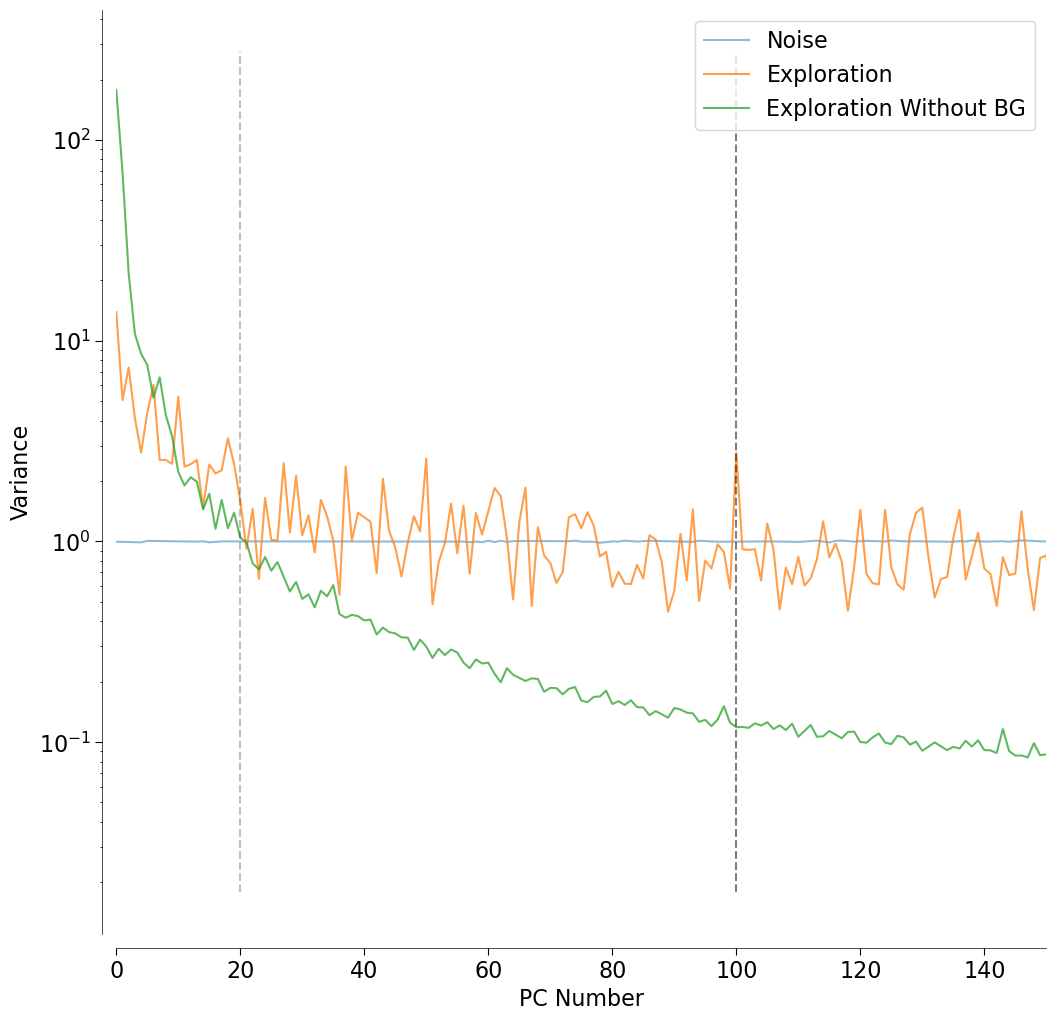

In [373]:
noise_transformed = pca.transform(noise_flat)
exploration_signal_transform = pca.transform(exploration_flat)
exploration_signal_transform_no_bg = pca.transform(exploration_flat_no_bg)

var_across = noise_transformed.var(axis=0)
exploration_var_across = exploration_signal_transform.var(axis=0)
exploration_var_across_no_bg = exploration_signal_transform_no_bg.var(axis=0)

plt.figure(figsize=(12, 12))
plt.plot(var_across, label='Noise', alpha=.5)
plt.plot(exploration_var_across, label='Exploration', alpha=.75)
plt.plot(exploration_var_across_no_bg, label='Exploration Without BG', alpha=.75)
plt.xlabel('PC Number')
plt.ylabel('Variance')
plt.yscale('log')
y_lims = plt.gca().get_ylim()
plt.vlines(x=previous_rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--', alpha=0.25)
plt.vlines(x=rewarded_dim, ymin=y_lims[0], ymax=y_lims[1], color='k', ls='--', alpha=0.5)
plt.legend()
make_axis_nice()
plt.xlim([0, 150])
plt.pause(.1)